In [22]:
import streamlit as st
import numpy as np
import pandas as pd
import math

from PIL import Image, ImageDraw
from lego_colors import LEGO_COLORS_ALL
from lego_colors_round import LEGO_COLORS_ROUND
from lego_colors_square import LEGO_COLORS_SQUARE
from lego_colors_square_available import LEGO_COLORS_SQUARE_AVAILABLE
from utils import create_mosaic, draw_mosaic, draw_instructions, get_image_download_link, save_feedback_to_google_sheets


In [47]:
import math

def find_closest_lego_color(r, g, b, lego_colors):
    """Find the closest LEGO color to the given RGB input using CIE Lab color space."""
    # Clamp RGB values to [0, 255]
    r, g, b = max(0, min(255, float(r))), max(0, min(255, float(g))), max(0, min(255, float(b)))
    
    # Convert input RGB to Lab
    input_lab = rgb_to_lab(r, g, b)
    
    # Compute closest color by CIE Lab color space distance
    min_dist = float('inf')
    closest = None
    for name, hex_code, lr, lg, lb in lego_colors:
        color_lab = rgb_to_lab(lr, lg, lb)
        # Calculate Delta E (CIE76 color difference)
        dist = math.sqrt(
            (input_lab[0] - color_lab[0]) ** 2 + 
            (input_lab[1] - color_lab[1]) ** 2 + 
            (input_lab[2] - color_lab[2]) ** 2
        )
        if dist < min_dist:
            min_dist = dist
            closest = {
                "name": name,
                "hex": hex_code,
                "rgb": (lr, lg, lb),
                "distance": dist
            }
    return closest

def rgb_to_xyz(r, g, b):
    """Convert RGB to XYZ color space."""
    # Normalize RGB values
    r = r / 255
    g = g / 255
    b = b / 255
    
    # Apply gamma correction
    r = r ** 2.2 if r > 0.04045 else r / 12.92
    g = g ** 2.2 if g > 0.04045 else g / 12.92
    b = b ** 2.2 if b > 0.04045 else b / 12.92
    
    # Convert to XYZ using sRGB matrices
    r *= 100
    g *= 100
    b *= 100
    
    x = r * 0.4124 + g * 0.3576 + b * 0.1805
    y = r * 0.2126 + g * 0.7152 + b * 0.0722
    z = r * 0.0193 + g * 0.1192 + b * 0.9505
    
    return [x, y, z]

def xyz_to_lab(x, y, z):
    """Convert XYZ to Lab color space."""
    # Use D65 white point
    xn = 95.047
    yn = 100.0
    zn = 108.883
    
    # Normalize XYZ values
    x = x / xn
    y = y / yn
    z = z / zn
    
    # Apply cube root approximation
    x = x ** (1/3) if x > 0.008856 else (7.787 * x) + (16/116)
    y = y ** (1/3) if y > 0.008856 else (7.787 * y) + (16/116)
    z = z ** (1/3) if z > 0.008856 else (7.787 * z) + (16/116)
    
    L = (116 * y) - 16
    a = 500 * (x - y)
    b = 200 * (y - z)
    
    return [L, a, b]

def rgb_to_lab(r, g, b):
    """Convert RGB directly to Lab color space."""
    xyz = rgb_to_xyz(r, g, b)
    return xyz_to_lab(xyz[0], xyz[1], xyz[2])

In [48]:

find_closest_lego_color(228, 228, 228, LEGO_COLORS_SQUARE_AVAILABLE)



{'name': 'Lavender',
 'hex': '#E1D5ED',
 'rgb': (225, 213, 237),
 'distance': 13.506084021504547}

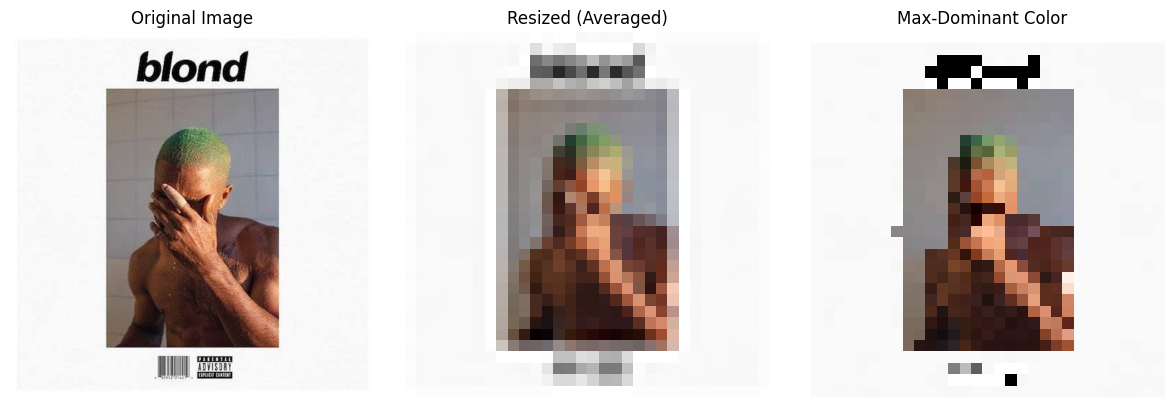

In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import os

# Load the sample image
image_path = "sample1.jpg"
if os.path.exists(image_path):
    original_image = Image.open(image_path).convert("RGB")
else:
    raise FileNotFoundError("sample.png not found in working directory.")

# Downscale parameters
mosaic_size = 32  # e.g. 32x32 LEGO grid

# Resize the image to the target mosaic size
resized_image = original_image.resize((mosaic_size, mosaic_size), Image.Resampling.LANCZOS)
resized_np = np.array(resized_image)

# Implement Max-Dominant Color strategy
def compute_dominant_color_blockwise(image, block_size):
    img_np = np.array(image)
    h, w, _ = img_np.shape
    blocks_y = h // block_size
    blocks_x = w // block_size

    mosaic = np.zeros((blocks_y, blocks_x, 3), dtype=np.uint8)

    for y in range(blocks_y):
        for x in range(blocks_x):
            block = img_np[y*block_size:(y+1)*block_size, x*block_size:(x+1)*block_size]
            block_flat = block.reshape(-1, 3)
            counts = Counter(map(tuple, block_flat))
            dominant_color = counts.most_common(1)[0][0]
            mosaic[y, x] = dominant_color

    return Image.fromarray(mosaic, "RGB")

# Generate result with max-dominant strategy using block size of 10 (adjustable)
block_size = max(original_image.size) // mosaic_size
dominant_image = compute_dominant_color_blockwise(original_image, block_size)

# Display original vs resized vs dominant color
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(resized_image)
axes[1].set_title("Resized (Averaged)")
axes[1].axis("off")

axes[2].imshow(dominant_image)
axes[2].set_title("Max-Dominant Color")
axes[2].axis("off")

plt.tight_layout()
plt.show()


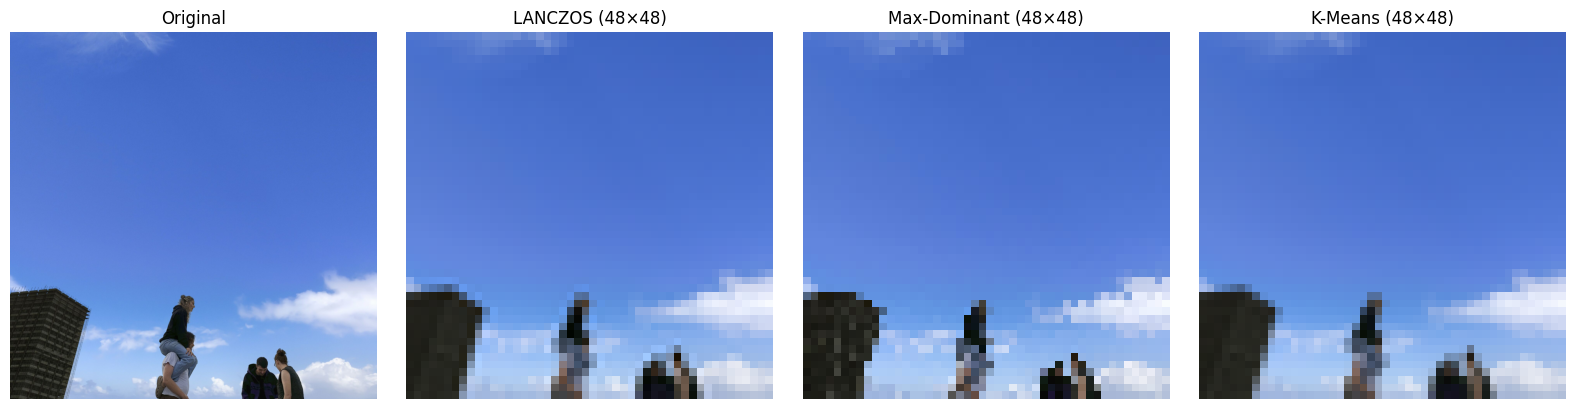

In [20]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.cluster import KMeans
import os

# === CONFIGURATION ===
image_path = "sample3.jpg"
mosaic_size = 48           # Output mosaic resolution (e.g. 48×48)
block_size = 4             # Pixels per block
resized_dim = mosaic_size * block_size

# === Load and resize image ===
if os.path.exists(image_path):
    image = Image.open(image_path).convert("RGB")
else:
    raise FileNotFoundError("Image not found.")

# Resize original image to an even multiple of the mosaic size
image_resized = image.resize((resized_dim, resized_dim), Image.Resampling.LANCZOS)

# === Method 1: LANCZOS Downscale ===
averaged_image = image.resize((mosaic_size, mosaic_size), Image.Resampling.LANCZOS)

# === Method 2: Max-Dominant Color ===
def compute_dominant_color_blockwise(image, block_size):
    img_np = np.array(image)
    h, w, _ = img_np.shape
    blocks_y = h // block_size
    blocks_x = w // block_size
    mosaic = np.zeros((blocks_y, blocks_x, 3), dtype=np.uint8)

    for y in range(blocks_y):
        for x in range(blocks_x):
            block = img_np[y*block_size:(y+1)*block_size, x*block_size:(x+1)*block_size]
            flat = block.reshape(-1, 3)
            dominant = Counter(map(tuple, flat)).most_common(1)[0][0]
            mosaic[y, x] = dominant

    return Image.fromarray(mosaic, "RGB")

dominant_image = compute_dominant_color_blockwise(image_resized, block_size)

# === Method 3: K-Means per block ===
def compute_kmeans_color_blockwise(image, block_size, n_clusters=1):
    img_np = np.array(image)
    h, w, _ = img_np.shape
    blocks_y = h // block_size
    blocks_x = w // block_size
    mosaic = np.zeros((blocks_y, blocks_x, 3), dtype=np.uint8)

    for y in range(blocks_y):
        for x in range(blocks_x):
            block = img_np[y*block_size:(y+1)*block_size, x*block_size:(x+1)*block_size]
            flat = block.reshape(-1, 3)
            if flat.shape[0] == 0:
                continue
            try:
                kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
                kmeans.fit(flat)
                color = kmeans.cluster_centers_[0].astype(np.uint8)
            except:
                color = np.array([0, 0, 0], dtype=np.uint8)
            mosaic[y, x] = color

    return Image.fromarray(mosaic, "RGB")

kmeans_image = compute_kmeans_color_blockwise(image_resized, block_size)

# === Plot all ===
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
axes[0].imshow(image)
axes[0].set_title("Original")
axes[0].axis("off")

axes[1].imshow(averaged_image)
axes[1].set_title("LANCZOS (48×48)")
axes[1].axis("off")

axes[2].imshow(dominant_image)
axes[2].set_title("Max-Dominant (48×48)")
axes[2].axis("off")

axes[3].imshow(kmeans_image)
axes[3].set_title("K-Means (48×48)")
axes[3].axis("off")

plt.tight_layout()
plt.show()


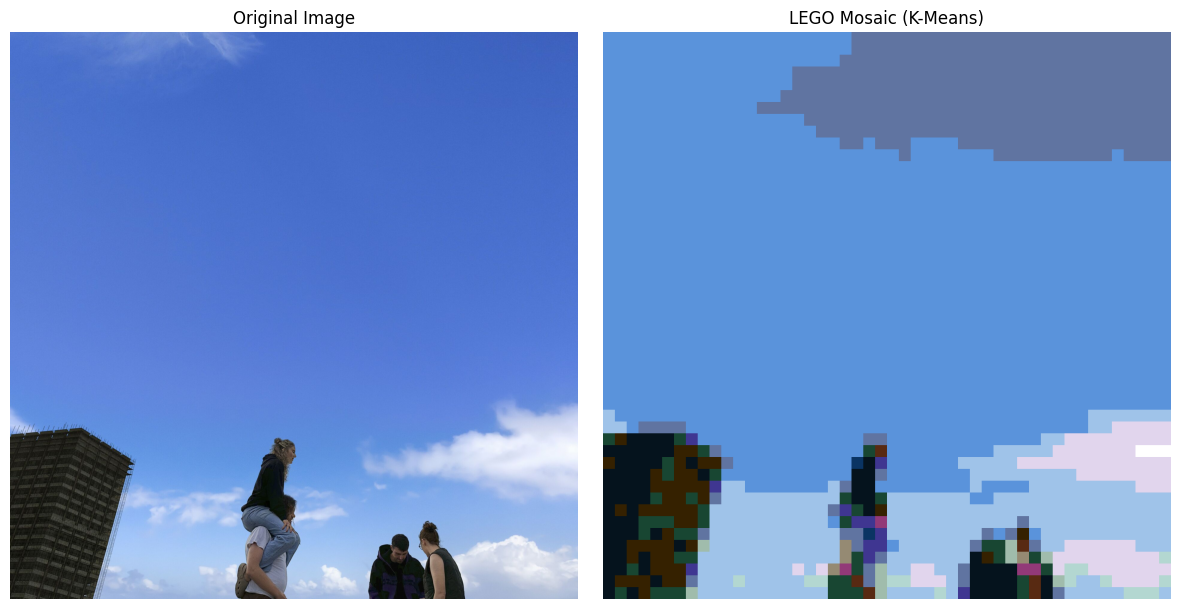

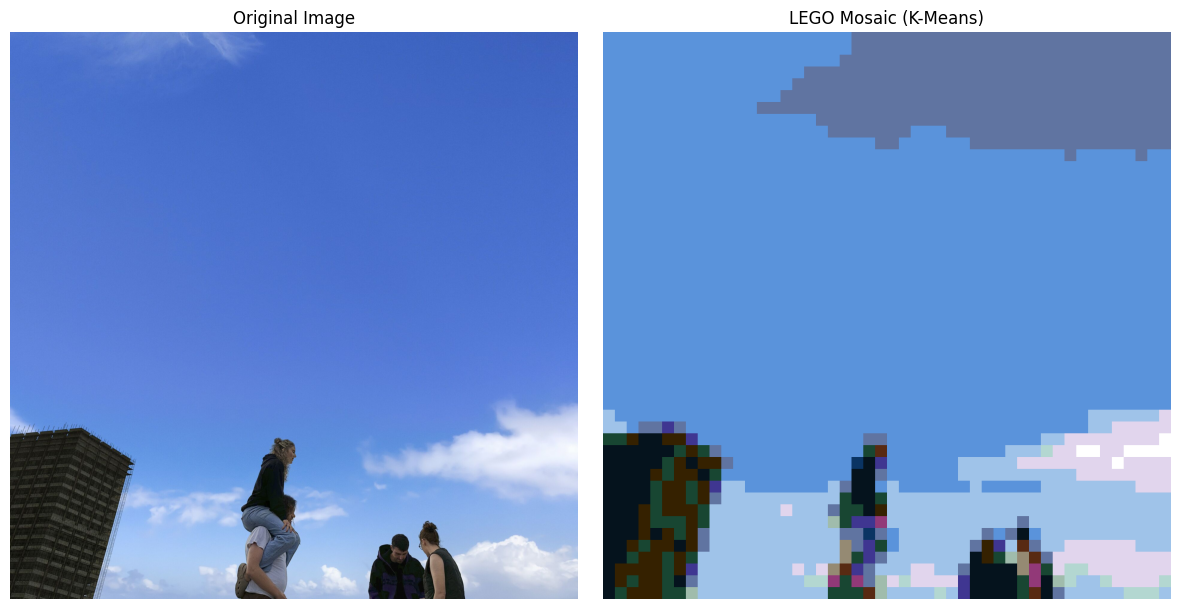

In [28]:
from lego_colors_square_available import LEGO_COLORS_SQUARE_AVAILABLE
from utils import *
import gspread

# Load your sample image
sample_image_path = "sample3.jpg"  # Change to your file name
image = Image.open(sample_image_path)

# Generate the mosaic
mosaic_data, color_counts = create_mosaic(image, mosaic_size=48, lego_colors=LEGO_COLORS_SQUARE_AVAILABLE, use_kmeans=True)

# Draw the result
mosaic_img = draw_mosaic(mosaic_data, pixel_size=10)

# Show original and mosaic
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(mosaic_img)
axes[1].set_title("LEGO Mosaic (K-Means)")
axes[1].axis("off")
plt.tight_layout()
plt.show()

# Load your sample image
sample_image_path = "sample3.jpg"  # Change to your file name
image = Image.open(sample_image_path)

# Generate the mosaic
mosaic_data, color_counts = create_mosaic(image, mosaic_size=48, lego_colors=LEGO_COLORS_SQUARE_AVAILABLE, use_kmeans=False)

# Draw the result
mosaic_img = draw_mosaic(mosaic_data, pixel_size=10)

# Show original and mosaic
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(mosaic_img)
axes[1].set_title("LEGO Mosaic (K-Means)")
axes[1].axis("off")
plt.tight_layout()
plt.show()